### Imports:

In [1]:
import pandas as pd
import numpy as np
from importlib import reload
from sklearn.metrics import confusion_matrix
import src.functions as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier as AD
reload(F)

<module 'src.functions' from '/Users/elliottsaslow/gaalvanize/week_5_notes/profit_curves/dsi-profit-curve/src/functions.py'>

### Intuitive understanding of Profit Curves
#### 1. Problem Statement:
Looking at a data set of wireless phone subscribers, we need to predict if a subscriber is going to cancel their service.  We can use trees to predict the probabilities of someone canceling or _churning_.

There is an associated cost with this, and I am going to look how to maximize the profit for the company.  What is a profit curve? It is taking features of a data point and transforming deciding whether is will belong to a certain group.  This is based on a calculated probability between 0 and 1.  It is then possible to get these probabilities out and look out the performance of the model.  By setting a different threshhold for deciding which it class it belongs to, we can maximize the point where we decide to try to keep the customer from canceling their phone service.


**Load in the Data**

In [2]:
df = F.read_data('data/churn.csv')
X,y = F.clean(df)
X.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


I wrote a function that calculates the confution matrix defined as the following:

||**pred y**|**pred N**|
|:-:|:-:|:-:|
|**actual Y**|TP|FN|
|**actual N**|FP|TN|

The code is below:

```
def standard_confusion_matrix(y_true,y_predict):
    tp = np.sum((y_predict == 1) & (y_predict == y_true))
    fp = np.sum((y_predict == 1) & (y_true == 0))
    fn = np.sum((y_predict == 0) & (y_true == 1))
    tn = np.sum((y_predict == 0) & (y_true == y_predict))
    
    confusion_matrix = np.array([[tp,fn],[fp,tn]])
    return confusion_matrix
```

Use logistic regression and trees to output a predeicted probabilty that a certain data point belonged to certain class.  In this case, based on a the features of a data point, we are dividing the data set into two groups.
- people who cancel their serivce
- people who keep their phone serivce

The cost matrix for this is

||**pred cancel**|**pred Not cancel**|
|:-:|:-:|:-:|
|**actual cancel**|79 TP|0 FN|
|**actual Not cancel**|-20 FP|0 TN|

where actually saving a subscriber saves 79 and but falsly identifying one costs 20 dollars.

Lets take a look at what we are working on splitting with this data

The image shows a good split in terms of information gain and how this type of split would allow a model to classify different points.  Also notice the imbalance btween the classes which we will need to deal with later.

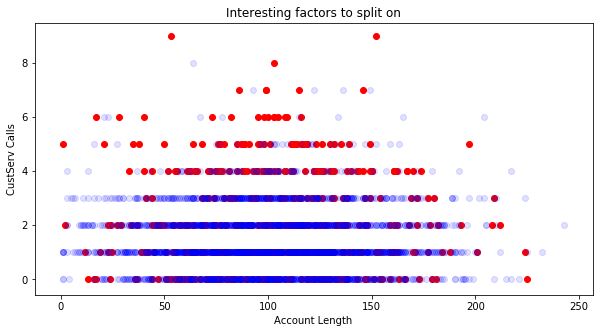

In [3]:
reload(F)
_,ax = plt.subplots(1,1,figsize=(10,5))

#Image: Account length vs customer Serice calls
F.scatter_two_cols(df,"Account Length",'CustServ Calls',y,ax);
ax.set_xlabel("Account Length");
ax.set_ylabel('CustServ Calls');
ax.set_title('Interesting factors to split on');


#### Review of ROC curves:
In statistics, a receiver operating characteristic curve, i.e. ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

This allows us to understand where the model is performing well, or performing badly.  

#### Connection to Profit Curves:
A cost can be associated with predicting a correct response and similarly there is a cost with predicting a incorrectly.  For example, if the user does end up canceling their phone service, the company loses money.  As well, if the compnay sends an email with a coupon, the user has a higher probability of staying and therfore saving the company money.  

Using this, we can calculate the price of each incorrect and correct classification. Below is the profit curve with a verticle line placed at the maximum profit for the company.  Nice!

The percentage of correct classification for 
model: RandomForestClassifier is:  95.324 %
--------------------------------------------------
The percentage of correct classification for 
model: LogisticRegression is:  86.211 %
--------------------------------------------------
The percentage of correct classification for 
model: GradientBoostingClassifier is:  95.564 %
--------------------------------------------------
The percentage of correct classification for 
model: AdaBoostClassifier is:  95.324 %
--------------------------------------------------


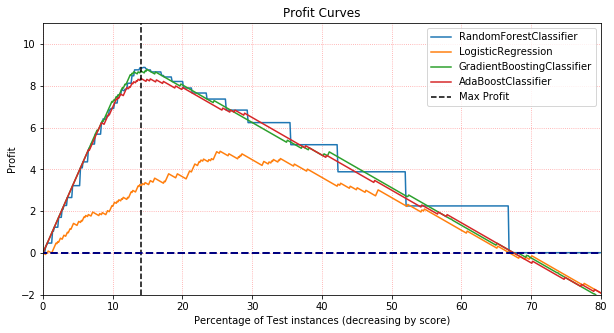

In [4]:
reload(F)

#split into train and test
X_train, X_test, y_train, y_test= train_test_split(X,y,shuffle = True)

#Define the Cost Matrix
cost_matrix = np.array([[79, -20], [ 0,   0]]).T

#Make the plot
_,ax = plt.subplots(1,1,figsize = (10,5))
models = [RF(n_estimators=50), LR(), GBC(),AD(GBC()\
                                               ,learning_rate=1)]

#plot out the profit curve for each model
for model in models:
    m,profits,p = F.plot_profit_curve(model, cost_matrix, X_train, X_test,\
                      y_train, y_test,ax)
    
    print('The percentage of correct classification for \nmodel:',
          model.__class__.__name__,
          'is: ',
          np.round(np.sum(m == y_test)/len(y_test)*100,3),
         '%')
    print('-'*50)
    
#Do some plotting stuff
ind = np.argmax(profits)
ax.axvline(p[ind],0,np.max(profits),\
           linestyle = '--', color = 'k',label = 'Max Profit')
ax.plot([-5, 110], [0, 0], color='navy', linestyle='--',
        lw = 2);

ax.legend();
ax.set_ylim(-2,11)
ax.set_xlim(0,80);

Nice So we are doing pretty well, but we havent yet taken a look at the problem of the class imbalance.  If 95% of the points belong to one class, our model can do a pretty good job of prediction by just predicting that class.  In reality thats not what we want.  Lets try to understand this a little better:

In [5]:
print(np.sum(y == 1)/len(y)*100,'% of the users churn in this data set')

14.491449144914492 % of the users churn in this data set


From above we can see that by just predicting the majority class, we can predict the correct class 84% of the time (1 - .1449).  Also looking above we see that some of our regressors are not that much better than that.  Can we do better?  **YES** . We need to manipulate the data a little bit so that our classes are more balanced!

#### Balancing - The Unbalanced Clasess:
- OverSampling
    - Over sample the data that has less points so that we get higher accuracy
- UnderSampling 
    - Under sample the data that has more points similar to above
- SMOTE
    - create some new data points that it can classify better
    
As is obvious from the data below, we definitly need to find a way to change the sampling.  Since Undersampling and Oversampling is pretty basic, I am going to write a function for SMOTE:

(3333, 17)

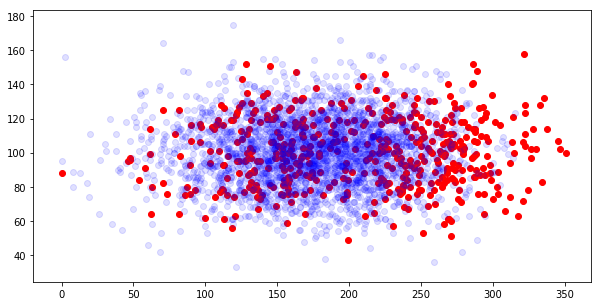

In [6]:
reload(F)
X.columns
_,ax = plt.subplots(1,1,figsize=(10,5))
F.scatter_two_cols(X,'Day Mins','Night Calls',y,ax)

This implimentation is messy, but I built it by hand (including the KNN part). You can reach out to me if you have questions about how it works.
Here is the psuedo code for the function:
```
Sythetic_obs = []
while len(Sythetic_obs) + len(minority_obs) < target:
    obs = random(observation)
    neighbor = random(KNN(obs,k))
    new_obs = []
    for feature in obs:
        weight = random #between 0 and 1
        new_feature_val = wieght*obs[feature]\
        + (1-wieght) *nieghbor[feature]
        new_observation[feature] = new_feature_value
    synthetic_observation.append(new_observation
```

In [7]:
from random import randint,choice,random
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNN

def Smote(X, y, majority_weight=.5):
    '''
    randomly discards observations from majority class
    so that output X, y have specified percentage of majority observations
    '''
    #calculate ratios
    syth_obs = []
    majority_ratio = sum(y)/len(y)
    majority_class = np.round(majority_ratio)
    minority_num = np.sum(y != majority_class)
    minority_obs = X[y != majority_class].reset_index()
    
    #while we havent met our target
    while(minority_num + len(syth_obs) < len(y) * majority_weight):
        #Find Random observation
        dist = []
        index = randint(0,len(minority_obs)-1)
        obs = np.array(minority_obs.loc[index,'Account Length':])
        
        #KNN Neighbors (self implimented)
        for i in range(minority_obs.shape[0]):
            if i != index:
                q = np.array(minority_obs.loc[i,'Account Length':],
                             dtype = 'float')
                dist.append([i,np.sqrt(sum(obs**2 + q**2))])
            
            
        #Get the index of the closest neighbors    
        df = pd.DataFrame(dist)
        df = df.sort_values([1])
        x = df[:][0:5]
        neighbor = np.array(X.loc[choice(list(x[0])),:])
        new = []
        
        #calculate values for the synthetic obs
        for j,feature in enumerate(obs):
            wieght = random()
            new_feature_value = round(wieght*feature\
                                      + (1-wieght)*neighbor[j],2)
            new.append(new_feature_value)
        syth_obs.append(new)
        
    return syth_obs

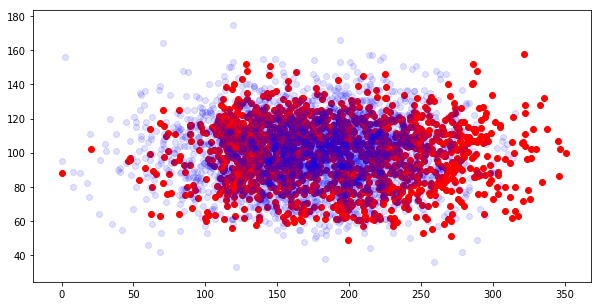

In [9]:
#Make sythentic obs
syth_obs = Smote(X, y, majority_weight=.5)
syth_obs = pd.DataFrame(syth_obs)
syth_obs.columns = X.columns

#add the new obs to the dataframe
y_new = pd.Series(np.ones(syth_obs.shape[0]))
X = pd.concat([X,syth_obs], axis=0).reset_index()
y = pd.concat([y,y_new], axis=0).reset_index()

#Scatter the results
_,ax = plt.subplots(1,1,figsize=(10,5))
F.scatter_two_cols(X,'Day Mins','Night Calls',np.array(y[0]),ax)

Cool!  The resampling worked!  This is rad.  Now lets take a look and see if we can actually get better results out of the new data:

The percentage of correct classification for 
model: RandomForestClassifier is:  98.082 %
--------------------------------------------------
The percentage of correct classification for 
model: LogisticRegression is:  80.216 %
--------------------------------------------------
The percentage of correct classification for 
model: GradientBoostingClassifier is:  95.923 %
--------------------------------------------------
The percentage of correct classification for 
model: AdaBoostClassifier is:  98.681 %
--------------------------------------------------


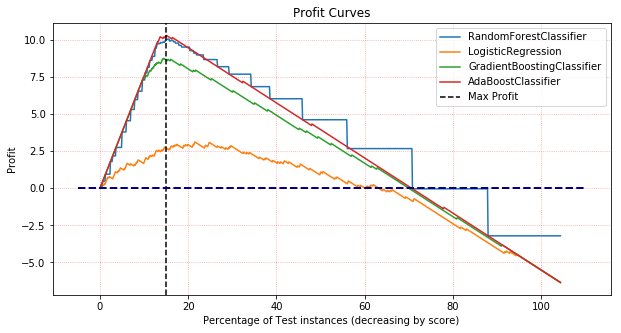

In [15]:
X_train, _, y_train, _= train_test_split(X,y[0],shuffle = True)
X_train.pop('index')
_,ax = plt.subplots(1,1,figsize = (10,5))
models = [RF(n_estimators=50), LR(), GBC(),AD(GBC()\
                                               ,learning_rate=1)]

#plot out the profit curve for each model
for model in models:
    m,profits,p = F.plot_profit_curve(model, cost_matrix, X_train, X_test,\
                      y_train, y_test,ax)
    
    print('The percentage of correct classification for \nmodel:',
          model.__class__.__name__,
          'is: ',
          np.round(np.sum(m == y_test)/len(y_test)*100,3),
         '%')
    print('-'*50)
    
#Do some plotting stuff
ind = np.argmax(profits)
ax.axvline(p[ind],0,np.max(profits),\
           linestyle = '--', color = 'k',label = 'Max Profit')
ax.plot([-5, 110], [0, 0], color='navy', linestyle='--',
        lw = 2);

ax.legend();


Nice! Our percent correct definitly increased with a couple of the classifiers!  I used the new data to train and then tested with the old data.  This is something I am going to have to spend more time looking into but still is pretty rad to see in real life.

Till next time

--E